# Verification of H2 pulses from Strict Partial Compilation

In [36]:
import sys
sys.path.append('../..')
import config
from fqc import uccsd, util, core
from fqc.models import Pulse

import numpy as np
from datetime import datetime

data_path = config.DATA_PATH
file_name = datetime.today().strftime('%h%d')

In [2]:
from quantum_optimal_control.helper_functions.grape_functions import transmon_gate
from quantum_optimal_control.main_grape.grape import Grape
from quantum_optimal_control.core import hamiltonian

In [3]:
d = 2  # this is the number of energy levels to consider (i.e. d-level qudits)
max_iterations = 6000
decay =  max_iterations / 2
convergence = {'rate':0.01, 'max_iterations': max_iterations,
               'conv_target':1e-3, 'learning_rate_decay':decay, 'min_grad': 1e-12, 'update_step': 20}
reg_coeffs = {}

In [4]:
N = 2
connected_qubit_pairs = util.get_nearest_neighbor_coupling_list(1, 2, directed=False)
H0 = hamiltonian.get_H0(N, d)
Hops, Hnames = hamiltonian.get_Hops_and_Hnames(N, d, connected_qubit_pairs)
states_concerned_list = hamiltonian.get_full_states_concerned_list(N, d)
maxA = hamiltonian.get_maxA(N, d, connected_qubit_pairs)

In [5]:
circuit = uccsd.get_uccsd_circuit('H2')

In [33]:
U_all = util.get_unitary(circuit)
print(U_all)

[[-0.05437642-0.15574664j -0.09576886-0.27430417j -0.15339842-0.43936855j
  -0.27016844-0.77382488j]
 [ 0.10724824+0.30718377j  0.27117209+0.77669959j -0.15020906-0.43023349j
  -0.03242342-0.09286818j]
 [ 0.14560414+0.41704393j  0.04912713+0.14071147j  0.23105198+0.6617863j
  -0.17790861-0.50957139j]
 [ 0.27016844+0.77382488j -0.15339842-0.43936855j -0.09576886-0.27430417j
   0.05437642+0.15574664j]]


In [6]:
slices = uccsd.get_uccsd_slices(circuit, granularity=1)
for slice in slices:
    if slice.parameterized:
        print('This slice is parameterized:')
    else:
        print('This slice is fixed:')
    print(slice.circuit)
    print('\n---------------------\n')

This slice is fixed:
         ┌───┐┌────────────┐┌───┐
q0_0: |0>┤ X ├┤ Rx(1.5708) ├┤ X ├
         └───┘└────────────┘└───┘
q0_1: |0>────────────────────────
                                 

---------------------

This slice is parameterized:
         ┌───────────┐
q1_0: |0>┤ Rz(7.316) ├
         └───────────┘
q1_1: |0>─────────────
                      

---------------------

This slice is fixed:
                       ┌───┐┌─────────────┐
q2_0: |0>──────────────┤ X ├┤ Rx(-1.5708) ├
         ┌────────────┐└───┘└─────────────┘
q2_1: |0>┤ Rx(1.5708) ├────────────────────
         └────────────┘                    

---------------------

This slice is parameterized:
                       
q3_0: |0>──────────────
         ┌────────────┐
q3_1: |0>┤ Rz(3.8229) ├
         └────────────┘

---------------------

This slice is fixed:
                             ┌────────────┐          
q4_0: |0>────────────────────┤ Rx(1.5708) ├──■───────
         ┌─────────────┐┌───┐└────────────┘┌─┴─┐┌─

In [17]:
# Hardcode fixed pulse sources:
h2fixed=["/project/ftchong/qoc/pranav/00002_Mar28.h5", "/project/ftchong/qoc/pranav/00008_Mar28.h5", "/project/ftchong/qoc/pranav/00017_Mar28.h5", "/project/ftchong/qoc/pranav/00018_Mar28.h5", "/project/ftchong/qoc/pranav/00028_Mar28.h5"]

Error: 9.992123e-04


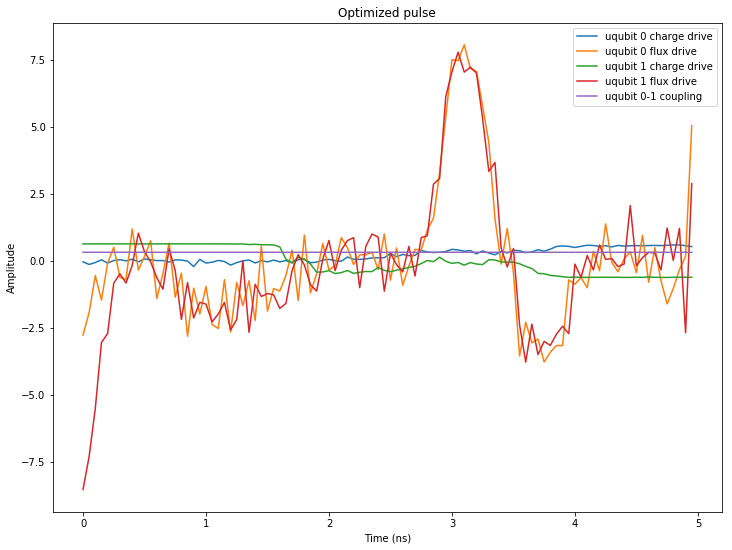

In [26]:
util.plot_pulse_from_file(h2fixed[3], save_plot=False)

In [40]:
all_res = []
errors = []
j = 0
for (i, slice) in enumerate(slices):
    if slice.parameterized:
        U = slice.unitary()
        total_time = util.circuitutil.get_max_pulse_time(slice.circuit)
        steps = int(total_time * 20)
        res = Grape(H0, Hops, Hnames, U, total_time, steps, states_concerned_list, convergence,
                         reg_coeffs=reg_coeffs,
                         use_gpu=False, sparse_H=False, method='Adam', maxA=maxA,
                         show_plots=False, file_name=file_name+"_"+str(i), data_path=data_path)
        all_res.append(res)
        errors.append(res.l)
    else:
        res = util.evol_pulse_from_file(h2fixed[j], save=True, out_file=file_name+"_"+str(i), out_path=data_path)
        all_res.append(res)
        errors.append(res.l)
        j = j + 1
        

data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_0.h5
Using 6 Taylor terms and 1 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :9.95e-04; Runtime: 0.1s; Iterations = 0, grads =   3.790e-06, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_0.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_1.h5
Using 7 Taylor terms and 0 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :3.07e-01; Runtime: 0.0s; Iterations = 0, grads =   1.

In [43]:
qubits = [0,1]
all_files = [data_path+"/00000_"+file_name+"_%d.h5" % i for i in range(len(slices))]
all_pulses = [Pulse(N, d, qubits, fname=f) for f in all_files]

In [44]:
res = core.concat_and_evol(N, d, all_pulses, U_all, file_name=file_name, data_path=data_path)

data saved at: /project/ftchong/qoc/yongshan/00014_Mar30.h5
Using 4 Taylor terms and 3 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :8.87e-03; Runtime: 0.5s; Iterations = 0, grads =   4.972e-02, unitary_metric = 0.99997
data saved at: /project/ftchong/qoc/yongshan/00014_Mar30.h5


In [47]:
print("Errors for all %d slices:" % len(errors))
print(errors)
print('\n---------------------\n')
print("Final concatenated error:")
print(res.l)

Errors for all 9 slices:
[0.0009949207, 0.0008921623, 0.0009997487, 0.00095051527, 0.0009964705, 0.0008729696, 0.0009993911, 0.0008211136, 0.0009993911]

---------------------

Final concatenated error:
0.008874416
